# thickness calculator

## libraries

In [1]:
import skfmm
from scipy.ndimage import distance_transform_edt
from scipy.signal import convolve2d
from main import *

import pandas as pd

from tqdm import tqdm

## old euclidean method

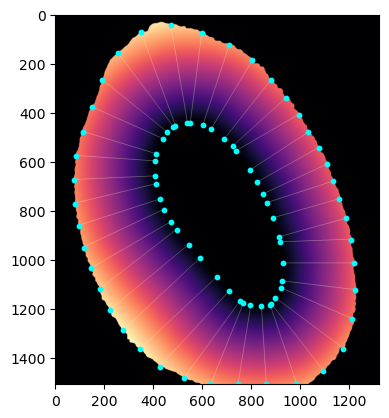

In [2]:
donut, res = get_picture2D('donut.tif')
point, _ = get_picture('point.tif')
height, width = donut.shape

donut_mask = donut != 0

# we should have only ventricle and outside regions
labeled, n = label(~ donut_mask)

if n != 2:
    raise ValueError('problem with masks, too many regions')

# outside label is the label of the pixel on the top left
outside_label = labeled[(0,0)]
outside_mask = labeled == outside_label
# ventricle is the other region
ventr_mask = (labeled != outside_label) & (~ donut_mask)

# show_pic(donut_mask, 'donut')

# calculating distance from ventricle
distance = np.zeros_like(donut, dtype=np.float64)
# keeping it only in the area of the donut
distance[donut_mask] = distance_transform_edt(~ventr_mask, sampling= res)[donut_mask]

# max value in the distance pic
max_dist = np.max(distance)

# find center of the ventricle
ventr_coords = center_of_mass(ventr_mask)

# find point in the reference pic
point_mask = point != 0
point_coords = center_of_mass(point_mask)


dx = point_coords[0] - ventr_coords[0]
dy = point_coords[1] - ventr_coords[1]
angle_0 = math.atan2(dy, dx)

max_length = np.linalg.norm(donut.shape)
# how many angles
n_angles = 40

results = pd.DataFrame(columns = ['angle_r', 'angle_d', 'thickness', 'ext_x', 'ext_y', 'vent_x', 'vent_y'])

test_img = distance.copy()

for i in range(n_angles):

    # angle of the ray
    a = 2*math.pi / n_angles * i + angle_0
    
    line_pixels = get_ray_pixels(donut, ventr_coords, a, res)

    cols = line_pixels[:,0]
    rows = line_pixels[:,1]



    # add radial picture line on top of picture
    # test_img[rows, cols] = max_dist

    # find the max ventricle distance along line
    current_thickness = np.max(distance[rows, cols])
    # where is the max distance along line
    current_index = np.argmax(distance[rows, cols])
    current_coords = [int(cols[current_index]), int(rows[current_index])]

    # circe centered in current point
    circ_pixels = get_circle_pixels(distance, current_coords, current_thickness, res)
    rows = circ_pixels[:,0]
    cols = circ_pixels[:,1]

    # add circle on top of picture
    # test_img[rows, cols] = max_dist

    # I need to set the pixels outside the tissue at some max value
    fake_distance = distance.copy()
    fake_distance[outside_mask] = max_dist
    vent_index = np.argmin(fake_distance[rows, cols])
    vent_coords = [int(cols[vent_index]), int(rows[vent_index])]

    r_line, c_line = get_line_pixels(current_coords, vent_coords)
    test_img[r_line, c_line] = max_dist

    results.loc[len(results)] = [a-angle_0, np.degrees(a-angle_0), current_thickness, *current_coords, *vent_coords]

# print(results)

plt.imshow(test_img, cmap = 'magma')
plt.scatter(results['ext_x'], results['ext_y'], s = 10, color = 'cyan')
plt.scatter(results['vent_x'], results['vent_y'], s = 10, color = 'cyan')
plt.show()

results.to_csv('result.csv')

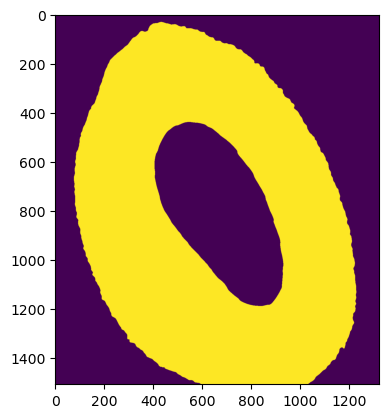

In [3]:
plt.imshow(donut)

# weird shape times 🎉

## pictures loading

In [4]:
# name = 'C1-29-08-2025 E12 R1 - E4 PBS-EdU+E6 GFP - EdU 647 - GFP+HuCD 488 - SOX2 555'
# name = 'C1-29-08-2025 E12 R1 f - E4 FGF2-EdU+E6 FGF2 - EdU 647 - GFP+HuCD 488 - SOX2 555'
# name = 'test_22'
name = 'test_mouse'

donut, res = get_picture2D(f'pics/{name}.tif')
point, _ = get_picture2D(f'pics/{name}_point.tif')
points, _ = get_picture2D(f'pics/{name}_points.tif')

if res[0] is None:
    res = (1,1)

c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")
c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")
c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")


531.91 880.10
smoothing factor = 11.64


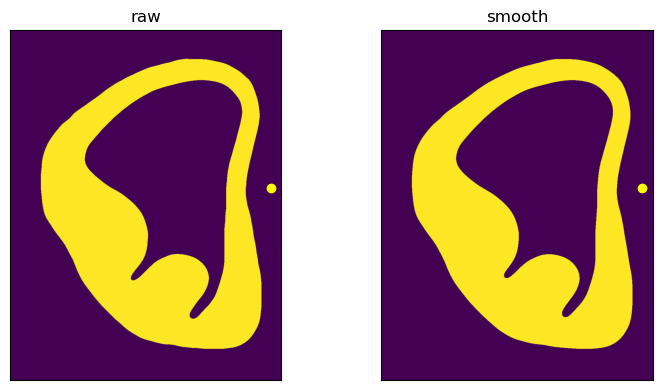

In [5]:
donut = np.pad(donut, pad_width=5, mode='constant', constant_values=0)
point = np.pad(point, pad_width=5, mode='constant', constant_values=0)
points = np.pad(points, pad_width=5, mode='constant', constant_values=0)

point_mask = point != 0
point_coords = center_of_mass(point_mask)

print(f'{point_coords[0]:.2f} {point_coords[1]:.2f}')


fig, axs = plt.subplots(1, 2, figsize = (8,4))
axs[0].set_title('raw')
axs[0].imshow(donut)

########################################
donut = smoothing(donut)
########################################

axs[1].set_title('smooth')
axs[1].imshow(donut)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

    ax.scatter(*point_coords[::-1], c = '#ffff00')

plt.tight_layout()

### get the ventricle

In [6]:
height, width = donut.shape

donut_mask = donut != 0

# we should have only ventricle and outside regions
labeled, n = label(~ donut_mask)

if n != 2:
    raise ValueError('problem with masks, too many regions')

# outside label is the label of the pixel on the top left
outside_label = labeled[(0,0)]
outside_mask = labeled == outside_label
# ventricle is the other region
ventr_mask = (labeled != outside_label) & (~ donut_mask)

center_of_mass(ventr_mask)

(np.float64(473.3413176016492), np.float64(554.8446510811877))

In [7]:
r_df = pd.DataFrame()

## finding the edge

### inside edge pixels

In [8]:
in_df = pd.DataFrame()

edge_in = find_edge(ventr_mask)

coords_in_np = np.argwhere(edge_in)
coords_in = [tuple(map(int,c)) for c in coords_in_np]

in_df['p_in'] = coords_in

### outside edge pixels

In [9]:
edge_out = find_edge(outside_mask)

coords_out_np = np.argwhere(edge_out).astype(int)
coords_out = [tuple(map(int,c)) for c in coords_out_np]

r_df['p_out'] = coords_out

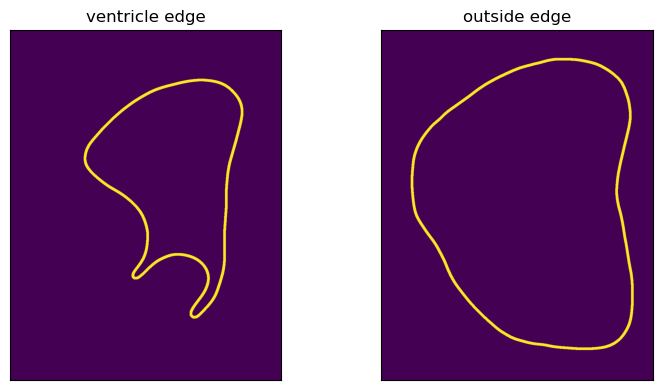

In [10]:
fig, axs = plt.subplots(1,2, figsize = (8,4))

axs[0].set_title('ventricle edge')
axs[0].imshow(thickening(edge_in))

axs[1].set_title('outside edge')
axs[1].imshow(thickening(edge_out))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

### all the outside pixels have a distance

In [11]:
tissue = np.ma.MaskedArray(~edge_in, outside_mask)

distance = skfmm.distance(tissue, dx=res)

r_df['dist'] = [distance[tuple(c)] for c in r_df['p_out']]

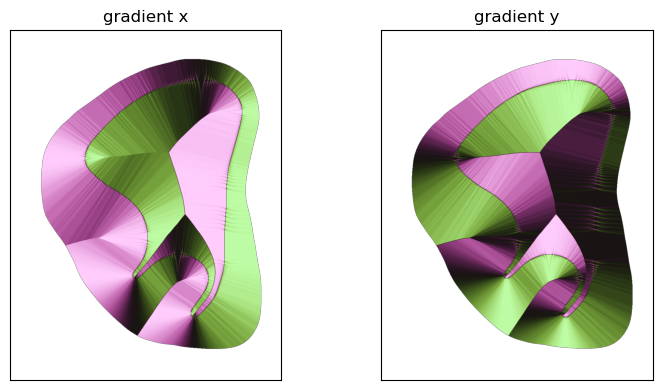

In [12]:
gy, gx = np.gradient(distance)

fig, axs = plt.subplots(1,2, figsize = (8,4))

axs[0].set_title('gradient x')
axs[0].imshow(gx, cmap='vanimo')

axs[1].set_title('gradient y')
axs[1].imshow(gy, cmap='vanimo')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

## follow the gradient

In [13]:
reference_in_list = []

for i, coord_out in enumerate(tqdm(coords_out_np)):

    coord_in, result_list = follow_gradient(distance, coord_out, edge_in, max_steps=1000)

    reference_in_list.append(coord_in)

r_df['p_in'] = reference_in_list


100%|██████████| 2607/2607 [00:40<00:00, 64.32it/s]


## find the reference angle

### this works if we have only one point

In [14]:
# find center of the ventricle
ventr_coords = center_of_mass(ventr_mask)

# find point in the reference pic
point_mask = point != 0
point_coords = center_of_mass(point_mask)

angle_0 = find_angle(point_coords, ventr_coords)

for index, row in in_df.iterrows():
    coord_in = row['p_in']

    current_angle = find_angle(coord_in, ventr_coords) - angle_0

    in_df.loc[index, 'angle'] = (current_angle / np.pi * 180) % 360


In [15]:
in_df.head()

,p_in,angle
0,"(168, 632)",86.027376
1,"(168, 633)",85.851131
2,"(168, 634)",85.675162
3,"(168, 635)",85.499474
4,"(168, 636)",85.324068


In [16]:
marks_df = pd.DataFrame()

labeled_mark, n_mark = label(points)

mark_coords = []
mark_sizes = []

for l in range(1, n_mark+1):
    current_mark = labeled_mark == l
    current_center = center_of_mass(current_mark)
    mark_coords.append(tuple(float(c) for c in current_center))

    mark_sizes.append(np.sum(current_mark))

marks_df['label'] = range(1, n_mark+1)
marks_df['coords'] = mark_coords
marks_df['size'] = mark_sizes

marks_df.head()

,label,coords,size
0,1,"(46.5, 746.5)",316
1,2,"(401.5, 51.5)",356
2,3,"(531.9133126934985, 880.1021671826626)",969
3,4,"(1131.5, 614.5)",316


In [17]:
point_1 = marks_df.loc[marks_df['size'] == marks_df['size'].max(), 'coords']
point_1

2    (531.9133126934985, 880.1021671826626)
Name: coords, dtype: object

In [18]:
in_df['quadrant'] = 0


for i in range(n_mark):

    current_mark = marks_df['coords'][i]
    current_lab = marks_df['label'][i]

    test = distance_transform_edt(labeled_mark != current_lab)

    base = np.ones_like(labeled_mark, dtype = float) * np.max(test)

    base[edge_in.astype(bool)] = test[edge_in.astype(bool)]

    current_in_coords = tuple(int(c) for c in np.unravel_index(np.argmin(base), base.shape))
    print(current_in_coords)

    in_df.loc[in_df['p_in'] == current_in_coords, 'quadrant'] = 1

    if marks_df['size'][i] == marks_df['size'].max():
        starting_in = current_in_coords
        print('here')

(177, 705)
(427, 252)
(519, 730)
here
(968, 618)


In [19]:
ordered_edge_in = ordered_edge_points(edge_in)

i = ordered_edge_in.index(starting_in)
ordered_edge_in = ordered_edge_in[i:] + ordered_edge_in[:i]

order_map = {p: i for i, p in enumerate(ordered_edge_in)}
in_df['order_in'] = in_df['p_in'].map(order_map)

in_df = in_df.sort_values(by='order_in', ignore_index=True)

in_df['quadrant'] = np.cumsum(in_df['quadrant'])

In [20]:
in_df.head(10)

,p_in,angle,quadrant,order_in
0,"(519, 730)",355.597894,1,0
1,"(518, 730)",355.904619,1,1
2,"(517, 730)",356.212183,1,2
3,"(516, 730)",356.520573,1,3
4,"(515, 730)",356.829774,1,4
5,"(514, 730)",357.139770,1,5
6,"(513, 730)",357.450547,1,6
7,"(512, 730)",357.762089,1,7
8,"(511, 730)",358.074380,1,8
9,"(510, 730)",358.387406,1,9


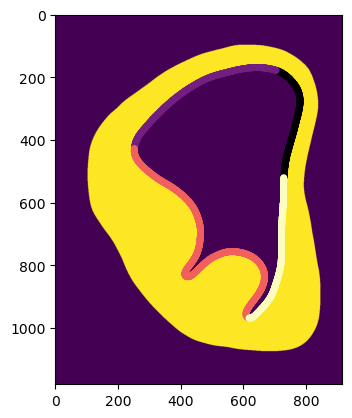

In [21]:
coords = np.array(in_df['p_in'])
rows, cols = zip(*coords)

plt.imshow(donut)
plt.scatter(cols, rows, s=15, c=in_df['quadrant'], cmap = 'magma')

In [22]:
r_df.head()

,p_out,dist,p_in
0,"(98, 585)",74.542788,"(172, 598)"
1,"(98, 586)",74.380781,"(172, 598)"
2,"(98, 587)",74.225642,"(172, 598)"
3,"(98, 588)",74.066907,"(172, 598)"
4,"(98, 589)",73.896826,"(172, 598)"


In [23]:
r_df = r_df.merge(
    in_df,
    on='p_in',
    how='left'
)

r_df.head()

,p_out,dist,p_in,angle,quadrant,order_in
0,"(98, 585)",74.542788,"(172, 598)",92.058386,2.0,465.0
1,"(98, 586)",74.380781,"(172, 598)",92.058386,2.0,465.0
2,"(98, 587)",74.225642,"(172, 598)",92.058386,2.0,465.0
3,"(98, 588)",74.066907,"(172, 598)",92.058386,2.0,465.0
4,"(98, 589)",73.896826,"(172, 598)",92.058386,2.0,465.0


In [24]:
r_df['order_in_norm'] = r_df['order_in'] / r_df['order_in'].max()

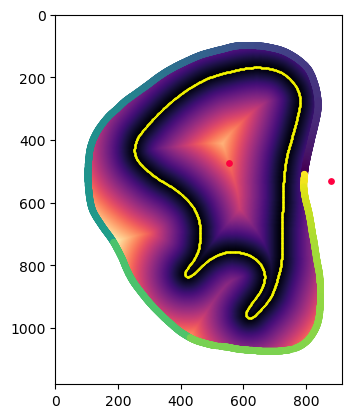

In [25]:
plt.imshow(distance, cmap='magma')
plt.scatter(*df_col_to_points(coords_out), s=15, c=r_df['angle'])
plt.scatter(*df_col_to_points(coords_in), s=0.1, c='yellow')

plt.scatter(*point_coords[1::-1], s=15, color = "#ff0040")
plt.scatter(*ventr_coords[::-1], s=15, color = "#ff0040")

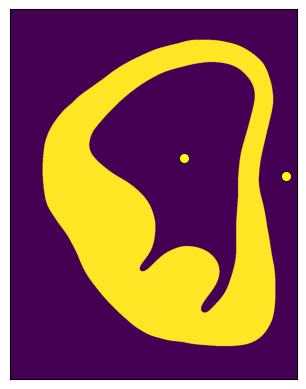

In [26]:
plt.imshow(donut)
plt.xticks([])
plt.yticks([])

plt.scatter(*point_coords[1::-1], s=30, color = "#ffff00")
plt.scatter(*ventr_coords[::-1], s=30, color = "#ffff00")

plt.savefig(f'plots/{name}_show.png')

## comparison

### 1 - angle on the ventricle

In [27]:
# output_angle_df = pd.DataFrame()

# gap = 1

# angles = range(0, 360, gap)
# output_angle_df['angle'] = angles

# # adding a padding to get the angles around the whole circle
# temp_low_padding = r_df.loc[r_df['angle'] > 360-gap].copy()
# temp_low_padding['angle'] = temp_low_padding['angle'] - 360

# temp_upp_padding = r_df.loc[r_df['angle'] < gap].copy()
# temp_upp_padding['angle'] = temp_upp_padding['angle'] + 360


# temp_r_df = pd.concat((r_df, temp_low_padding, temp_upp_padding), ignore_index=True)

# for i, a in enumerate(angles):
#     current_points = temp_r_df.loc[(temp_r_df['angle'] > a - gap) & (temp_r_df['angle'] < a + gap)]

#     output_angle_df.loc[i, 'dist'] = current_points['dist'].mean()


### 2 - unraveling the outside

In [28]:
ordered_edge_out = ordered_edge_points(edge_out)

starting_point_out = r_df.loc[r_df['angle'] == r_df['angle'].min()].iloc[0]['p_out']


i = ordered_edge_out.index(starting_point_out)
ordered_edge_out = ordered_edge_out[i:] + ordered_edge_out[:i]


order_map = {p: i for i, p in enumerate(ordered_edge_out)}
r_df['order_out'] = r_df['p_out'].map(order_map)

In [29]:
r_df['order_out_norm'] = r_df['order_out'] / r_df['order_out'].max()

In [30]:
# k = 360

# r_df['binned_out'] = pd.cut(r_df['order_out'], bins=k)

# output_perim_df = pd.DataFrame()
# output_perim_df['perc'] = np.arange(k) / k * 100

# output_perim_df['dist'] = (
#     r_df
#     .groupby('binned_out')[['dist']]
#     .mean()
#     .reset_index()
# )['dist']

# output_perim_df['angle'] = (
#     r_df
#     .groupby('binned_out')[['angle']]
#     .mean()
#     .reset_index()
# )['angle']

### 3 - unraveling the ventricle

## finding reference angles

In [31]:
r_df['angle_mark'] = 0
ref_angles = [0, 90, 180, 270]

for ref_angle in ref_angles:
    r_df.loc[(r_df['angle'] - ref_angle).abs().idxmin(), 'angle_mark'] = 1

In [32]:
r_df['angle_mark'].unique()

array([0, 1])

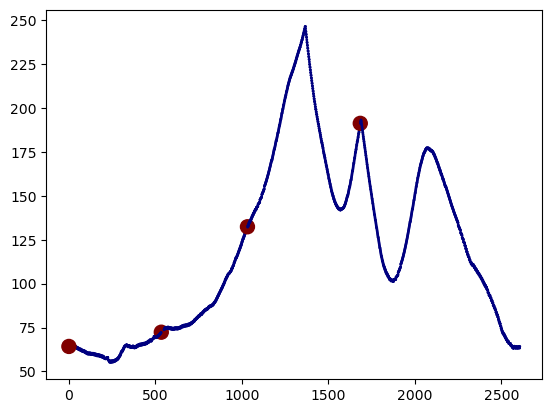

In [33]:
plt.scatter(r_df['order_out'], r_df['dist'], c=r_df['angle_mark'], s = r_df['angle_mark']*100 + 1, cmap='jet')

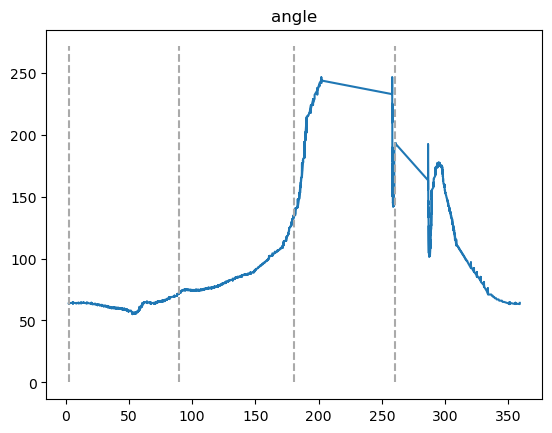

In [34]:
plot_ordered('angle', 'dist', df = r_df, name=name)

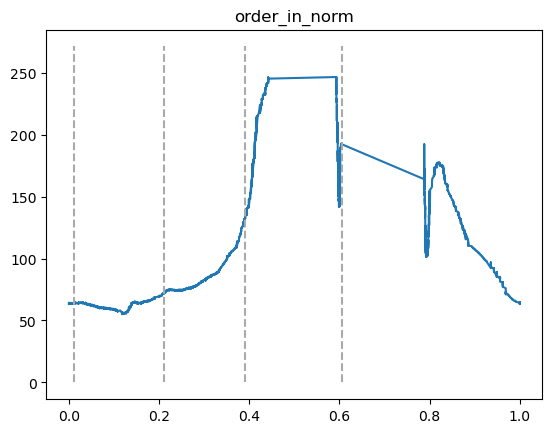

In [35]:
plot_ordered('order_in_norm', 'dist', df = r_df, name=name)

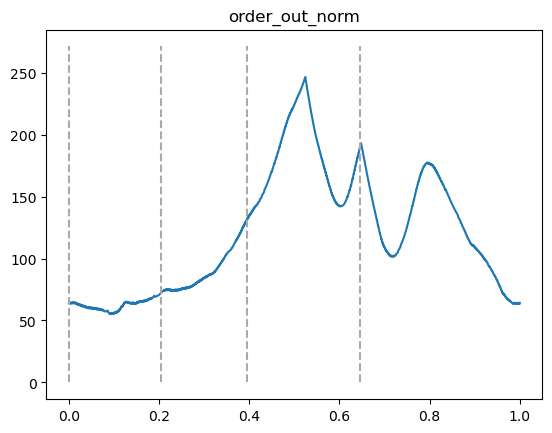

In [36]:
plot_ordered('order_out_norm', 'dist', df = r_df, name=name)

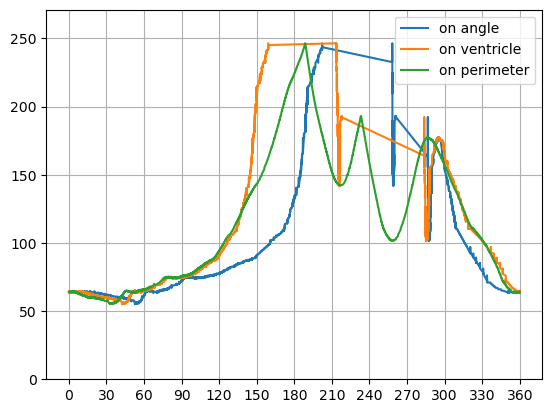

In [37]:
plt.title('')

r_df_sorted = r_df.sort_values(by='angle')
plt.plot(r_df_sorted['angle'], r_df_sorted['dist'], label='on angle')

r_df_sorted = r_df.sort_values(by='order_in')
plt.plot(r_df_sorted['order_in_norm']*360, r_df_sorted['dist'], label='on ventricle')

r_df_sorted = r_df.sort_values(by='order_out')
plt.plot(r_df_sorted['order_out_norm']*360, r_df_sorted['dist'], label='on perimeter')


plt.ylim(0, r_df['dist'].max()*1.1)
plt.legend()
plt.xticks(np.arange(0,390,30))
plt.grid()

plt.savefig(f'plots/{name}_comparison.png')

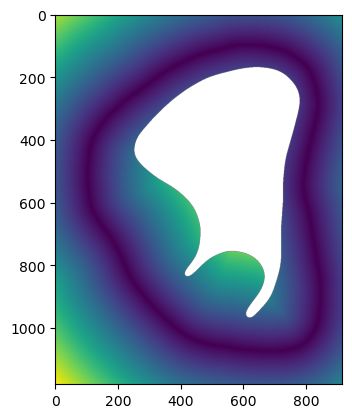

In [38]:
tissue_from_out = np.ma.MaskedArray(~edge_out, ventr_mask)

distance_from_out = skfmm.distance(tissue_from_out, dx=res)

plt.imshow(distance_from_out)

in_df['dist'] = [distance_from_out[tuple(c)] for c in in_df['p_in']]

In [34]:
in_df.head()

,p_in,angle,quadrant,order_in,dist
0,"(519, 730)",355.597894,1,0,63.253169
1,"(518, 730)",355.904619,1,1,63.294564
2,"(517, 730)",356.212183,1,2,63.349868
3,"(516, 730)",356.520573,1,3,63.419956
4,"(515, 730)",356.829774,1,4,63.505064


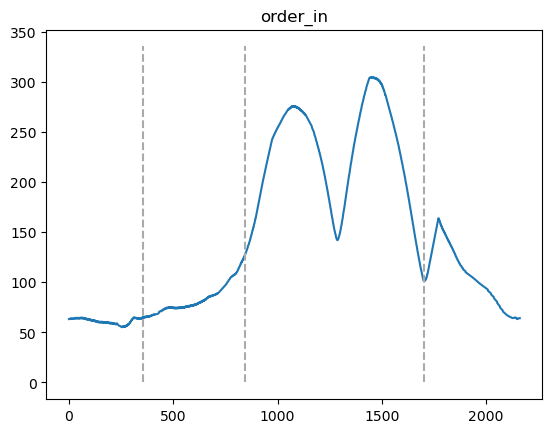

In [39]:
plot_ordered('order_in', 'dist', df = in_df)

In [83]:
r_df.to_csv('test.csv')

# summary

In [84]:
def analyze_thick_angle(donut, medial_point, res, smooth = True):
    # padding to avoid edge problems
    donut = np.pad(donut, pad_width=5, mode='constant', constant_values=0)
    medial_point = np.pad(medial_point, pad_width=5, mode='constant', constant_values=0)

    point_mask = point != 0
    point_coords = center_of_mass(point_mask)

    if smooth:
        donut = smoothing(donut)
    

    donut_mask = donut != 0

    # we should have only ventricle and outside regions
    labeled, n = label(~ donut_mask)

    if n != 2:
        raise ValueError('problem with masks, too many regions')

    # outside label is the label of the pixel on the top left
    outside_label = labeled[(0,0)]
    outside_mask = labeled == outside_label
    # ventricle is the other region
    ventr_mask = (labeled != outside_label) & (~ donut_mask)


    r_df = pd.DataFrame()

    # inside edge
    edge_in = find_edge(ventr_mask)
    coords_in_np = np.argwhere(edge_in)
    coords_in = [c for c in coords_in_np]

    # outside edge
    edge_out = find_edge(outside_mask)
    coords_out_np = np.argwhere(edge_out).astype(int)
    coords_out = [tuple(map(int,c)) for c in coords_out_np]
    r_df['p_out'] = coords_out

    # distance
    tissue = np.ma.MaskedArray(~edge_in, outside_mask)
    distance = skfmm.distance(tissue, dx=res)
    r_df['dist'] = [distance[tuple(c)] for c in r_df['p_out']]

    # from outside pixel to inside reference
    reference_in_list = []
    for i, coord_out in enumerate(tqdm(coords_out_np)):
        coord_in, result_list = follow_gradient(distance, coord_out, edge_in, max_steps=1000)
        reference_in_list.append(coord_in)
    r_df['p_in'] = reference_in_list


    # find center of the ventricle
    ventr_coords = center_of_mass(ventr_mask)

    # find point in the reference pic
    point_mask = point != 0
    point_coords = center_of_mass(point_mask)

    angle_0 = find_angle(point_coords, ventr_coords)
    # from inside pixel to angle
    for index, row in r_df.iterrows():
        coord_in = row['p_in']
        current_angle = find_angle(coord_in, ventr_coords) - angle_0
        r_df.loc[index, 'angle'] = (current_angle / np.pi * 180) % 360
    
    
    # unravel the outside perimeter
    ordered_edge_out = ordered_edge_points(edge_out)
    starting_point_out = r_df.loc[r_df['angle'] == r_df['angle'].min()].iloc[0]['p_out']

    i_out = ordered_edge_out.index(starting_point_out)
    ordered_edge_out = ordered_edge_out[i_out:] + ordered_edge_out[:i_out]

    order_map = {p: i for i, p in enumerate(ordered_edge_out)}
    r_df['order_out'] = r_df['p_out'].map(order_map)
    r_df['order_out_norm'] = r_df['order_out']/r_df['order_out'].max()


    # unravel the inside perimeter
    ordered_edge_in = ordered_edge_points(edge_in)
    starting_point_in = r_df.loc[r_df['angle'] == r_df['angle'].min()].iloc[0]['p_in']

    i_in = ordered_edge_in.index(starting_point_in)
    ordered_edge_in = ordered_edge_in[i_in:] + ordered_edge_in[:i_in]

    order_map = {p: i for i, p in enumerate(ordered_edge_in)}
    r_df['order_in'] = r_df['p_in'].map(order_map)
    r_df['order_in_norm'] = r_df['order_in']/r_df['order_in'].max()

    # reference angles
    r_df['angle_mark'] = 0
    ref_angles = [0, 90, 180, 270]

    for ref_angle in ref_angles:
        r_df.loc[(r_df['angle'] - ref_angle).abs().idxmin(), 'angle_mark'] = 1
    

    return r_df

In [85]:
def analyze_thick_quad(donut, ref_points, res, smooth = True):
    # padding to avoid edge problems
    donut = np.pad(donut, pad_width=5, mode='constant', constant_values=0)
    points = np.pad(ref_points, pad_width=5, mode='constant', constant_values=0)

    # dealing with 4 ref points
    marks_df = pd.DataFrame()
    labeled_mark, n_mark = label(points)

    mark_coords = []
    mark_sizes = []

    for l in range(1, n_mark+1):
        current_mark = labeled_mark == l
        current_center = center_of_mass(current_mark)
        mark_coords.append(tuple(float(c) for c in current_center))

        mark_sizes.append(np.sum(current_mark))

    marks_df['label'] = range(1, n_mark+1)
    marks_df['coords'] = mark_coords
    marks_df['size'] = mark_sizes


    if smooth:
        donut = smoothing(donut)
    
    donut_mask = donut != 0

    # we should have only ventricle and outside regions
    labeled, n = label(~ donut_mask)

    if n != 2:
        raise ValueError('problem with masks, too many regions')

    # outside label is the label of the pixel on the top left
    outside_label = labeled[(0,0)]
    outside_mask = labeled == outside_label
    # ventricle is the other region
    ventr_mask = (labeled != outside_label) & (~ donut_mask)


    r_df = pd.DataFrame()

    # inside edge
    in_df = pd.DataFrame()

    edge_in = find_edge(ventr_mask)
    coords_in_np = np.argwhere(edge_in)
    coords_in = [tuple(map(int,c)) for c in coords_in_np]

    in_df['p_in'] = coords_in
    in_df['quadrant'] = 0

    for i in range(n_mark):
        current_mark = marks_df['coords'][i]
        current_lab = marks_df['label'][i]

        point_dist = distance_transform_edt(labeled_mark != current_lab)
        # we fill with the max dist value
        base = np.ones_like(labeled_mark, dtype = float) * np.max(point_dist)
        # we put the actual dist values only on the edge_in
        base[edge_in.astype(bool)] = point_dist[edge_in.astype(bool)]
        # coord of the minimum
        current_in_coords = tuple(int(c) for c in np.unravel_index(np.argmin(base), base.shape))

        in_df.loc[in_df['p_in'] == current_in_coords, 'quadrant'] = 1
        # if the point is the biggest, it means it's the medial
        if marks_df['size'][i] == marks_df['size'].max():
            starting_in = current_in_coords
    
    # order on ventricle perimeter
    ordered_edge_in = ordered_edge_points(edge_in)
    i = ordered_edge_in.index(starting_in)
    ordered_edge_in = ordered_edge_in[i:] + ordered_edge_in[:i]
    order_map = {p: i for i, p in enumerate(ordered_edge_in)}
    in_df['order_in'] = in_df['p_in'].map(order_map)
    in_df = in_df.sort_values(by='order_in', ignore_index=True)
    in_df['quadrant'] = np.cumsum(in_df['quadrant'])
    in_df['order_in_norm'] = in_df['order_in']/in_df['order_in'].max()

    # outside edge
    edge_out = find_edge(outside_mask)
    coords_out_np = np.argwhere(edge_out).astype(int)
    coords_out = [tuple(map(int,c)) for c in coords_out_np]
    r_df['p_out'] = coords_out

    # distance
    tissue = np.ma.MaskedArray(~edge_in, outside_mask)
    distance = skfmm.distance(tissue, dx=res)
    r_df['dist'] = [distance[tuple(c)] for c in r_df['p_out']]


    # from outside pixel to inside reference - following the gradient
    reference_in_list = []
    for i, coord_out in enumerate(tqdm(coords_out_np)):
        coord_in, result_list = follow_gradient(distance, coord_out, edge_in, max_steps=1000)
        reference_in_list.append(coord_in)
    r_df['p_in'] = reference_in_list

    r_df = r_df.merge(
        in_df,
        on='p_in',
        how='left'
    )

    
    # unravel the outside perimeter
    ordered_edge_out = ordered_edge_points(edge_out)
    starting_point_out = r_df.loc[r_df['quadrant'] == 1].iloc[0]['p_out']

    i_out = ordered_edge_out.index(starting_point_out)
    ordered_edge_out = ordered_edge_out[i_out:] + ordered_edge_out[:i_out]

    order_map = {p: i for i, p in enumerate(ordered_edge_out)}
    r_df['order_out'] = r_df['p_out'].map(order_map)
    r_df['order_out_norm'] = r_df['order_out']/r_df['order_out'].max()


    return r_df

# testing

c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")
c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")


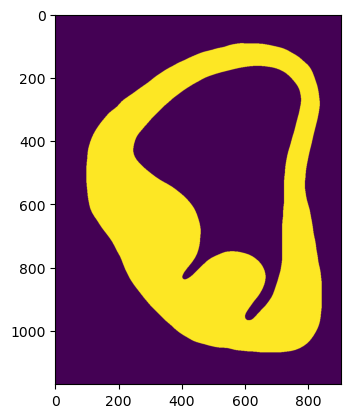

smoothing factor = 11.64


100%|██████████| 2607/2607 [00:41<00:00, 62.86it/s]


In [86]:
tissue, _ = get_picture2D('pics/test_mouse.tif')
res = (1,1)

points, _ = get_picture2D('pics/test_mouse_points.tif')

plt.imshow(tissue)
plt.show()

df = analyze_thick_quad(tissue, points, res)

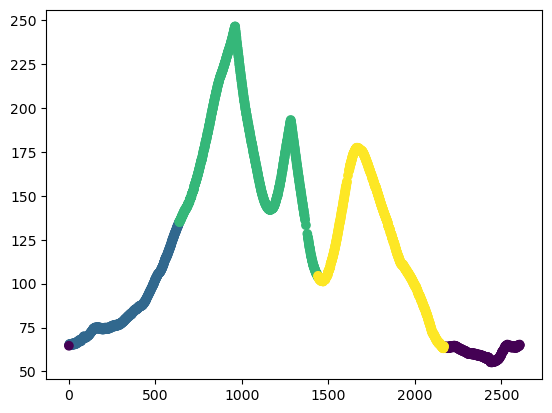

In [87]:
plt.scatter(df['order_out'], df['dist'], c=df['quadrant'])

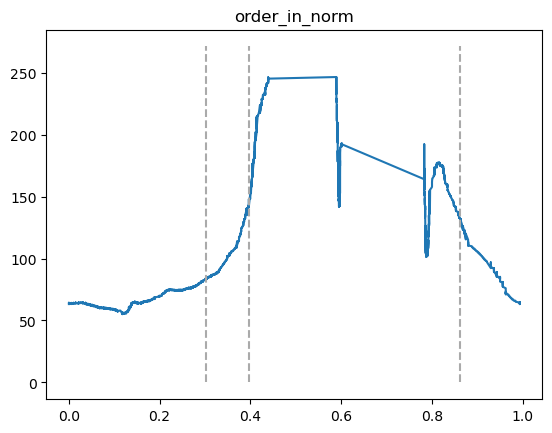

In [88]:
plot_ordered('order_in_norm', 'dist', df = df)

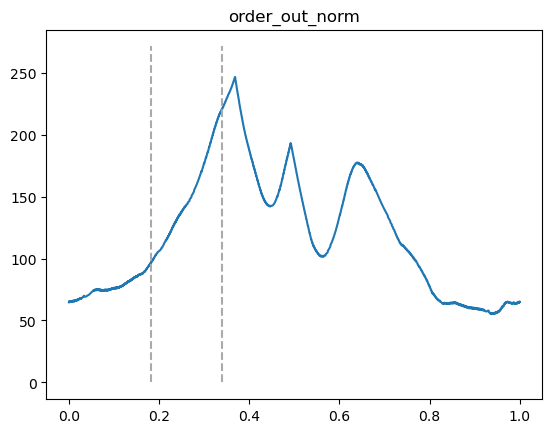

In [89]:
plot_ordered('order_out_norm', 'dist', df = df)